In [ ]:
pip install Boruta

In [ ]:
import pandas as pd
from datetime import datetime
import sklearn
from sklearn.preprocessing import LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb

In [ ]:
# Load the dataset
df = pd.read_csv('Clean_dataset.csv')

# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Encode the Result attribute with W:2, D:1, L:0
df['Result_Encoded'] = df['Result'].map({'W': 2, 'D': 1, 'L': 0})

# Encode the Venue attribute
df['Venue_Encoded'] = df['Venue'].map({'Home': 1, 'Away': 0})

# Identify non-numeric columns
non_numeric_columns = df.select_dtypes(include=['object']).columns.tolist()

# Convert non-numeric columns to numeric using Label Encoding
label_encoders = {}
for col in non_numeric_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Handle NaN values by filling them with the mean of the column
df.fillna(df.mean(), inplace=True)

# Split the dataset into training and testing sets
train_start_date = datetime(2021, 5, 23)
train_end_date = datetime(2023, 5, 28)
test_start_date = datetime(2023, 8, 11)
test_end_date = datetime(2024, 5, 19)

train_df = df[(df['Date'] >= train_start_date) & (df['Date'] <= train_end_date)]
test_df = df[(df['Date'] >= test_start_date) & (df['Date'] <= test_end_date)]

# Select features and target variable
features = train_df.drop(columns=['Date', 'Result', 'Result_Encoded', 'Venue'])
target = train_df['Result_Encoded']

# Select features for the test set
test_features = test_df.drop(columns=['Date', 'Result', 'Result_Encoded', 'Venue'])
test_target = test_df['Result_Encoded']

# Verify that all features are numeric and there are no NaN values
print("Feature Data Types:\n", features.dtypes)
print("Number of NaN values in features: ", features.isna().sum().sum())

Feature Data Types:
 Time             int64
Comp             int64
Round            int64
Day              int64
GF               int64
                 ...  
Captain          int64
Formation        int64
Opp Formation    int64
Referee          int64
Venue_Encoded    int64
Length: 110, dtype: object
Number of NaN values in features:  0


In [ ]:
# Initialize the random forest classifier
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# Initialize Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# Fit Boruta
boruta.fit(features.values, target.values)

# Get the selected features
selected_features = features.columns[boruta.support_].tolist()
print("Selected Features: ", selected_features)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	36
Tentative: 	22
Rejected: 	52
Iteration: 	9 / 100
Confirmed: 	36
Tentative: 	22
Rejected: 	52
Iteration: 	10 / 100
Confirmed: 	36
Tentative: 	22
Rejected: 	52
Iteration: 	11 / 100
Confirmed: 	36
Tentative: 	22
Rejected: 	52
Iteration: 	12 / 100
Confirmed: 	37
Tentative: 	21
Rejected: 	52
Iteration: 	13 / 100
Confirmed: 	37
Tentative: 	18
Rejected: 	55
Iteration: 	14 / 100
Confirmed: 	37
Tentative: 	18
Rejected: 	55
Iteration: 	15 / 100
Confirmed: 	37
Tentative: 	18
Rejected: 	55
Iteration: 	16 / 100
Confirmed: 	37
Tenta

In [ ]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features[selected_features], target, test_size=0.2, random_state=42)

# Initialize models with correct classes for XGBoost
models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'XGBoost': xgb.XGBClassifier(objective='multi:softmax', num_class=3)
}

# Initialize a list to store results
results = []

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    # Evaluate the best model on the test set
    y_test_pred = model.predict(test_features[selected_features])
    test_accuracy = accuracy_score(test_target, y_test_pred)

    # Calculate percentage of games correctly predicted for draws and victories of home and away team
    conf_matrix = confusion_matrix(test_target, y_test_pred)
    total_games = conf_matrix.sum()
    correct_draws = conf_matrix[1][1]
    correct_home_wins = conf_matrix[2][2]
    correct_away_wins = conf_matrix[0][0]

    draw_percentage = (correct_draws / total_games) * 100
    home_win_percentage = (correct_home_wins / total_games) * 100
    away_win_percentage = (correct_away_wins / total_games) * 100

    # Append results to the list
    results.append({
        'Model': name,
        'Accuracy': test_accuracy,
        'Draw Percentage': draw_percentage,
        'Home Win Percentage': home_win_percentage,
        'Away Win Percentage': away_win_percentage
    })

# Create a DataFrame to present the results
results_df = pd.DataFrame(results)

results_df

,Model,Accuracy,Draw Percentage,Home Win Percentage,Away Win Percentage
0,KNN,0.397368,3.421053,13.552632,22.763158
1,Random Forest,0.972368,19.868421,38.157895,39.210526
2,SVM,0.486842,0.000000,21.315789,27.368421
3,XGBoost,0.989474,21.052632,38.684211,39.210526


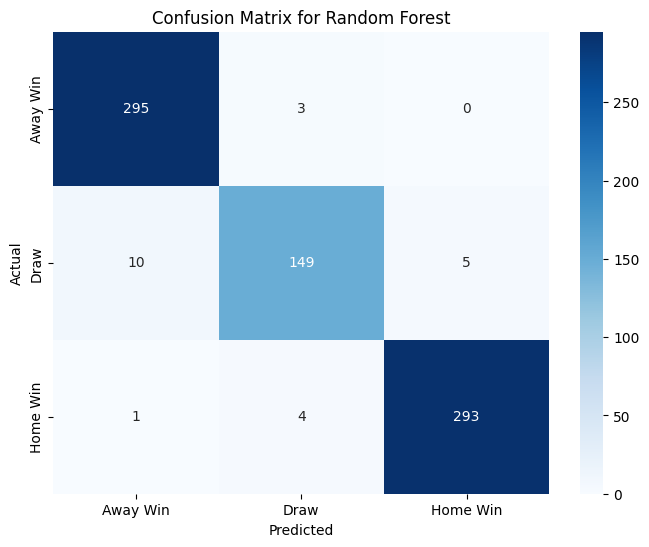

In [ ]:
# Train the RF model
RF_model = models['Random Forest']
RF_model.fit(features, target)

# Predict on the test set
y_test_pred = RF_model.predict(test_features)

# Calculate confusion matrix for Random Forest
conf_matrix = confusion_matrix(test_target, y_test_pred)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Away Win', 'Draw', 'Home Win'], yticklabels=['Away Win', 'Draw', 'Home Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()

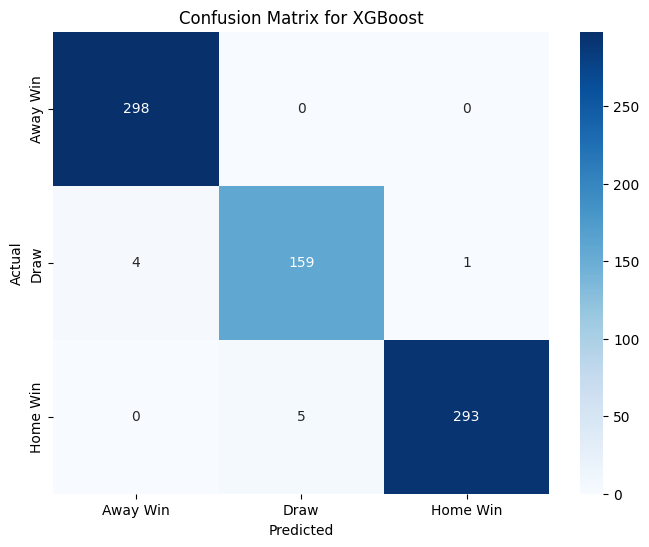

In [ ]:
# Train the XGBoost model
xgb_model = models['XGBoost']
xgb_model.fit(features, target)

# Predict on the test set
y_test_pred = xgb_model.predict(test_features)

# Calculate confusion matrix for the XGBoost model
conf_matrix = confusion_matrix(test_target, y_test_pred)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Away Win', 'Draw', 'Home Win'], yticklabels=['Away Win', 'Draw', 'Home Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for XGBoost')
plt.show()

In [ ]:
# Map encoded team numbers back to original team names
team_encoder = label_encoders['Team']
opponent_encoder = label_encoders['Opponent']
test_df['Team'] = test_df['Team'].map(lambda x: team_encoder.inverse_transform([x])[0])
test_df['Opponent'] = test_df['Opponent'].map(lambda x: opponent_encoder.inverse_transform([x])[0])

<ipython-input-55-ffa4bc105bc6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Team'] = test_df['Team'].map(lambda x: team_encoder.inverse_transform([x])[0])
<ipython-input-55-ffa4bc105bc6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Opponent'] = test_df['Opponent'].map(lambda x: opponent_encoder.inverse_transform([x])[0])


In [ ]:
# Calculate accuracy for each game prediction
accuracies = []
for i in range(len(test_df)):
    actual_result = test_df.iloc[i]['Result_Encoded']
    predicted_result = y_test_pred[i]
    accuracies.append(accuracy_score([actual_result], [predicted_result]))

test_df['Prediction Accuracy'] = accuracies

<ipython-input-63-eec528b6145d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Prediction Accuracy'] = accuracies


In [ ]:
test_df[['Team', 'Opponent', 'GF', 'GA', 'Result', 'Prediction Accuracy']]

,Team,Opponent,GF,GA,Result,Prediction Accuracy
140,Manchester City,Burnley,3,0,2,1.0
141,Manchester City,Newcastle Utd,1,0,2,1.0
142,Manchester City,Sheffield Utd,2,1,2,1.0
143,Manchester City,Fulham,5,1,2,1.0
144,Manchester City,West Ham,3,1,2,1.0
...,...,...,...,...,...,...
895,Sheffield United,Manchester Utd,2,4,1,1.0
896,Sheffield United,Newcastle Utd,1,5,1,1.0
897,Sheffield United,Nott'ham Forest,1,3,1,1.0
898,Sheffield United,Everton,0,1,1,1.0


In [ ]:
# Create a points table based on predictions
teams = list(set(test_df['Team']).union(set(test_df['Opponent'])))
points_table = pd.DataFrame(teams, columns=['Team'])
points_table['W'] = 0
points_table['D'] = 0
points_table['L'] = 0
points_table['GF'] = 0
points_table['GA'] = 0
points_table['Points'] = 0

team_stats = {team: {'W': 0, 'D': 0, 'L': 0, 'GF': 0, 'GA': 0, 'Points': 0} for team in teams}
accuracies = []

for i in range(len(test_df)):
    actual_result = test_df.iloc[i]['Result_Encoded']
    predicted_result = y_test_pred[i]
    accuracies.append(accuracy_score([actual_result], [predicted_result]))

    team = test_df.iloc[i]['Team']
    opponent = test_df.iloc[i]['Opponent']
    team_goals = test_df.iloc[i]['GF']
    opponent_goals = test_df.iloc[i]['GA']

    if predicted_result == 2: # Team win predicted correctly.
        team_stats[team]['W'] += 1
        team_stats[opponent]['L'] += 1
        team_stats[team]['Points'] += 3

    elif predicted_result == 1: # Draw predicted correctly.
        team_stats[team]['D'] += 1
        team_stats[opponent]['D'] += 1
        team_stats[team]['Points'] += 1
        team_stats[opponent]['Points'] += 1

    elif predicted_result == 0: # Opponent win predicted correctly.
        team_stats[opponent]['W'] += 1
        team_stats[team]['L'] += 1
        team_stats[opponent]['Points'] += 3

    # Update goals for and against.
    team_stats[team]['GF'] += team_goals
    team_stats[opponent]['GF'] += opponent_goals
    team_stats[team]['GA'] += opponent_goals
    team_stats[opponent]['GA'] += team_goals

# Calculate average prediction accuracy for each game.
average_accuracy = sum(accuracies) / len(accuracies)

# Create final points table with prediction accuracy.
final_points_table = pd.DataFrame.from_dict(team_stats, orient='index')
final_points_table.reset_index(inplace=True)
final_points_table.rename(columns={'index': 'Team'}, inplace=True)
final_points_table['Prediction Accuracy'] = average_accuracy

In [ ]:
final_points_table_sorted = final_points_table.sort_values(by='Points', ascending=False)

final_points_table_sorted

,Team,W,D,L,GF,GA,Points,Prediction Accuracy
21,Manchester City,57,11,8,192,68,182,0.986842
9,Arsenal,56,10,10,182,58,178,0.986842
1,Liverpool,47,21,8,172,82,162,0.986842
27,Aston Villa,40,16,20,152,122,136,0.986842
24,Chelsea,36,17,23,154,126,125,0.986842
14,Crystal Palace,26,20,30,114,116,98,0.986842
26,Everton,26,18,32,80,102,96,0.986842
18,Fulham,26,17,33,110,122,95,0.986842
17,Bournemouth,25,19,32,108,134,94,0.986842
8,Brentford,20,18,38,112,130,78,0.986842
